# Hypothetical patients (with and without thrombolysis)
using 1 k-fold

### Plain English summary

Use the model trained in notebook 040 to show the multiclass mRS distributions (individual mRS + cumulative distributions) for hypothetical patients with/without thrombolysis.

Patient examples:
* Someone similar to clinical trial: no prior disability, age 72.5, no afib diagnosis, NIHSS 15, precise onset time
* As #1 but mild stroke
* As #1 but severe stroke
* As #1 but prior mRS 3 or 4
* As #1 but with afib
* As #1 but age 87.5
* As #1 but imprecise onset time

### Model and data
XGBoost model, trained in notebook 040\
7 features: ["prior_disability", "stroke_severity", "stroke_team", "age", "onset-to-thrombolysis-time", "any_afib_diagnosis", "precise_onset_known"]\
First k-fold\

### Aims

### Observations




#### Further work

#### Resources
pip install plotly
pip install dash

## Import libraries

In [1]:
# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from dataclasses import dataclass

import pickle

from os.path import exists

import time
import datetime

Report the time duration to run notebook

In [2]:
start_time = time.time()

Select the features for the model

In [3]:
selected_features = ["prior_disability", "stroke_severity", "stroke_team", 
                     "age", "onset_to_thrombolysis_time", "any_afib_diagnosis", 
                     "precise_onset_known"]
n_features = len(selected_features)
selected_features.append('discharge_disability')

# Set the default onset to treatment time as 2 hours
ott_default = 120 

Set kfold to use

In [4]:
k = 0

## Set up paths and filenames

For consistency, the folders end with "/" and the text for filenames include no trailing "_".

In [5]:
@dataclass(frozen=True)
class Paths:
    '''Singleton object for storing paths to data and database.'''
    image_save_path: str = './saved_images'
    model_save_path: str = './saved_models'
    data_save_path: str = './saved_data'
    data_read_path: str = '../data_processing/output/kfold_5fold'
    model_text: str = f'xgb_mrs_distributions'
    notebook: str = '060_'

paths = Paths()

Create output folders if needed

In [6]:
path = paths.image_save_path
if not os.path.exists(path):
    os.makedirs(path)
        
path = paths.model_save_path
if not os.path.exists(path):
    os.makedirs(path)

path = paths.data_save_path
if not os.path.exists(path):
    os.makedirs(path)

## Import data

Data has previously been split into 5 stratified k-fold splits.

In [7]:
# Read in training set, restrict to chosen features & store
filename = os.path.join(paths.data_read_path, 
                        ('03_train_' + str(k) + '.csv'))
train = pd.read_csv(filename)
train = train[selected_features]

filename = os.path.join(paths.data_read_path, 
                        ('03_test_' + str(k) + '.csv'))
test = pd.read_csv(filename)
test = test[selected_features]

Get list of features

In [8]:
feature_names = list(train)

### One hot the categorical features

Convert some categorical features to one hot encoded features.

Define a function

In [9]:
def convert_feature_to_one_hot(df, feature_name, prefix):
    """
    Converts a categorical feature into a one hot encoded feature
    
    Args:
        df [dataframe]: training or test dataset
        feature_name [str]: feature to convert to one hot encoding
        prefix [str]: string to use on new feature

    Return:
        df [dataframe]: One hot encoded representation of the feature
    """

    # One hot encode a feature
    df_feature = pd.get_dummies(
        df[feature_name], prefix = prefix)
    df = pd.concat([df, df_feature], axis=1)
    df.drop(feature_name, axis=1, inplace=True)

    return(df)

Set up two lists for the one hot encoding. 

A list of the feature names that are categorical and to be converted using one hot encoding.
A list of the prefixes to use for these features.

In [10]:
features_to_one_hot = ["stroke_team", "weekday"]
list_prefix = ["team", "weekday"]

For each feature in the list, for each train and test dataset, convert to one hot encoded.

In [11]:
for feature, prefix in zip(features_to_one_hot, list_prefix):
    if feature in selected_features:
        train = convert_feature_to_one_hot(train, feature, prefix)
        test = convert_feature_to_one_hot(test, feature, prefix)

Feature names with one hot encoding

In [12]:
feature_names_ohe = list(train)
feature_names_ohe.remove("discharge_disability")
n_features = len(feature_names_ohe)

print(f"There are {len(feature_names)} original features (before one-hot encoding)")
print(f"There are {n_features} features (after one-hot encoding)")

There are 8 original features (before one-hot encoding)
There are 124 features (after one-hot encoding)


Extract the team names

In [13]:
ohe_stroke_team_features = [col for col in feature_names_ohe if col.startswith('team')]

Create dataframe of the key patient prototypes (user defines the patients)

In [14]:
stroke_severity = ['15', '1', '40', '15', '15', '15', '15', '15']
prior_disability = ['1', '1', '1', '3', '4', '1', '1', '1']
any_afib_diagnosis = ['0', '0', '0', '0', '1', '0', '0', '0']
age = ['72.5','72.5','72.5','72.5','72.5','72.5', '87.5', '72.5']
precise_onset_known = ['1', '1', '1', '1', '1', '1', '1', '0']

list_index = ['clinical_trial', 'mild_stroke', 'severe_stroke', 
              'prior_disability_3', 'prior_disability_4', 'afib_diagnosis', 
              'older', 'imprecise_onset_time']

df_patient_prototypes = pd.DataFrame(columns=feature_names_ohe)
df_patient_prototypes["prior_disability"] = prior_disability
df_patient_prototypes["stroke_severity"] = stroke_severity
df_patient_prototypes["age"] = age
df_patient_prototypes["any_afib_diagnosis"] = any_afib_diagnosis
df_patient_prototypes["precise_onset_known"] = precise_onset_known
df_patient_prototypes["index"] = list_index

# Set not attend all hosptials (afterwards set to attend one of them)
for col in ohe_stroke_team_features:
    df_patient_prototypes[col] = ['0', '0', '0', '0', '0', '0', '0', '0']

# Set patients as going to the specified team
team_attend = "team_Royal Lancaster Infirmary"
df_patient_prototypes[team_attend] = ['1', '1', '1', '1', '1', '1', '1', '1']

df_patient_prototypes.set_index("index", inplace=True)

n_patients = df_patient_prototypes.shape[0]

df_patient_prototypes

,prior_disability,stroke_severity,age,onset_to_thrombolysis_time,any_afib_diagnosis,precise_onset_known,team_Addenbrooke's Hospital,team_Basildon University Hospital,team_Blackpool Victoria Hospital,team_Bradford and Airedale SU,...,team_Whiston Hospital HASU,team_William Harvey Hospital,team_Wirral Arrowe Park Hospital,team_Withybush General Hospital,team_Worcestershire Royal Hospital,team_Worthing Hospital,team_Wycombe General Hospital,team_Yeovil District Hospital,team_York Hospital,team_Ysbyty Gwynedd
index,,,,,,,,,,,,,,,,,,,,,
clinical_trial,1,15,72.5,NaN,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
mild_stroke,1,1,72.5,NaN,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
severe_stroke,1,40,72.5,NaN,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
prior_disability_3,3,15,72.5,NaN,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
prior_disability_4,4,15,72.5,NaN,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
afib_diagnosis,1,15,72.5,NaN,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
older,1,15,87.5,NaN,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
imprecise_onset_time,1,15,72.5,NaN,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Load XGBoost model

Load model trained in notebook 040 on 7 features.

In [15]:
# Model filename
filename = os.path.join(paths.model_save_path, 
                ('040_xgb_7_features_5fold_0.p'))

# Check if exists
file_exists = exists(filename)

if file_exists:
# Load models
    with open(filename, 'rb') as filehandler:
        model = pickle.load(filehandler)
else:
    # Define and Fit model
    print("Run notebook 040, that fits the model")

Plot (want to create a subplot per patient, with the two mRS probability distributions on the same plot)

In [16]:
def create_df_for_bar_plot(df):
    """ 
    
    Args:
        df [dataframe]:
    
    Return:
        df_bar [dataframe]: 
    
    """
    df_bar  = pd.DataFrame()
    df_bar["Treatment"] = (["Treatment"] * 7) + (["No treatment"] * 7)
    df_bar["Discharge disability"] = np.append(df.index.values, df.index.values)
    df_bar["Probability"] = np.append(df["with"], df["without"])
    return(df_bar)

For each patient prototype, set up a dataframe containing two of these patients, one getting IVT, and one not.

Use the XGBoost model to predict the probability of being in each discharge disability.

Plot result in a bar plot. A plot per patient.

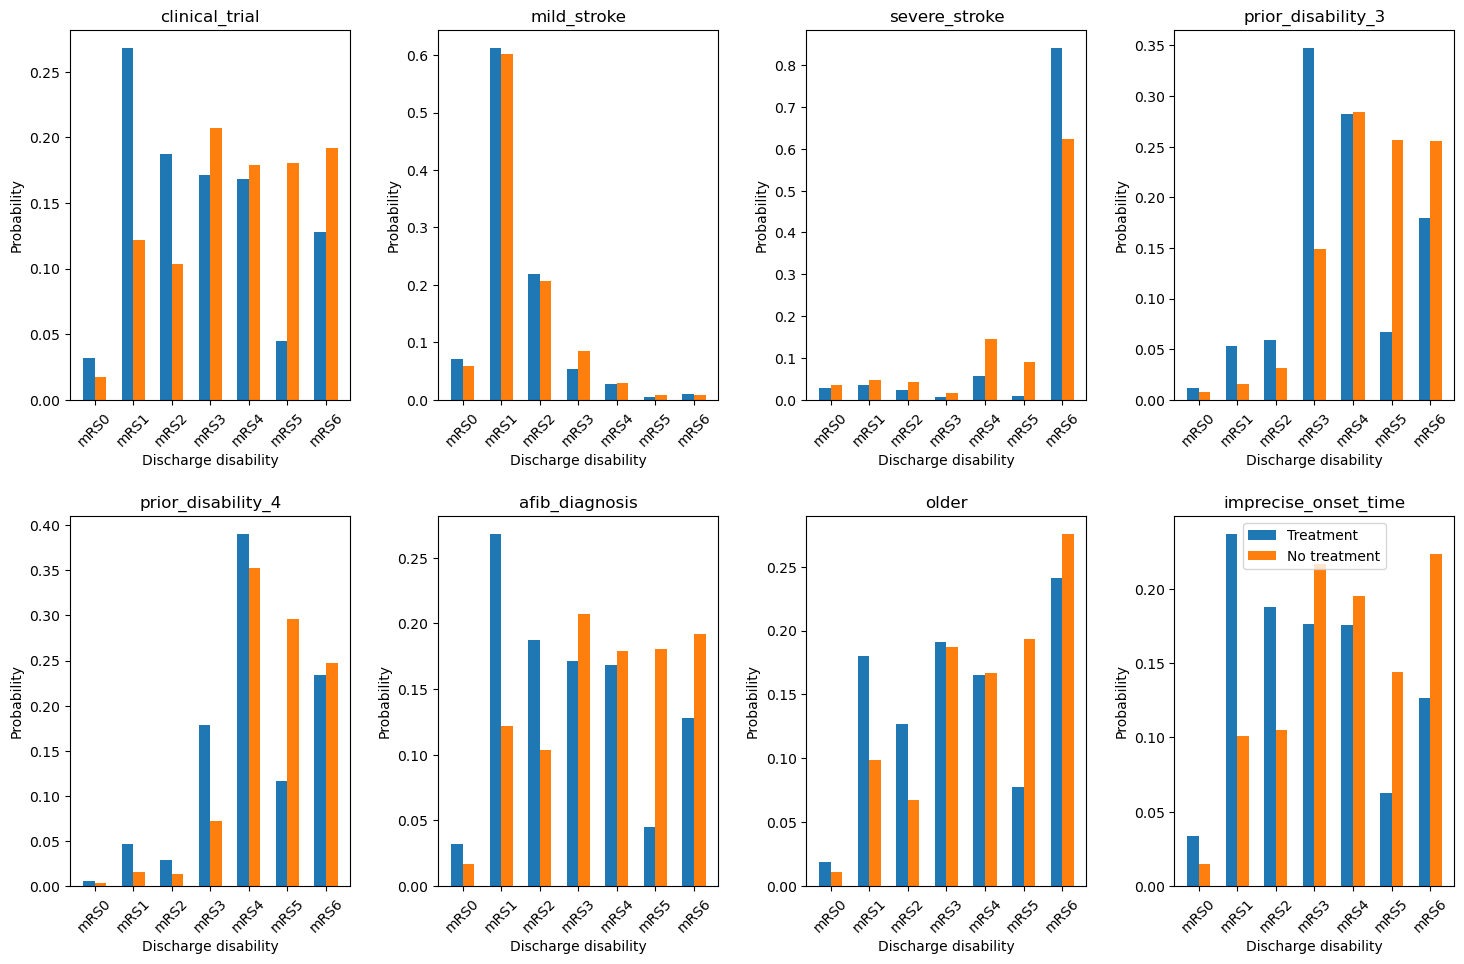

In [17]:
list_get_treatment = ["Treatment","No treatment"]
list_onset_to_thrombolysis_time = [ott_default, -100]

columns=["mRS0","mRS1","mRS2","mRS3","mRS4","mRS5","mRS6"]
index=["with","without"]

# Position of bars on x-axis
ind = np.arange(len(columns))

width = 0.3

fig = plt.figure(figsize=(15, 10))

for patient_loc in range(n_patients):
#    title = df_patient_prototypes.index.values[patient_loc]
    title = df_patient_prototypes.index[patient_loc]
    # take details of this patient
    df_patient_details = pd.DataFrame(columns=list(df_patient_prototypes), 
                                      index=range(len(list_get_treatment)))

    # take exact copy of row
    df_patient_details.iloc[0] = df_patient_prototypes.iloc[patient_loc,:]
    df_patient_details.iloc[1] = df_patient_prototypes.iloc[patient_loc,:]

    # make first copy have, and the second copy not have thrombolysis treatment 
    # (either not get, or get at 2 hours)
    df_patient_details["onset_to_thrombolysis_time"] = (
                                            list_onset_to_thrombolysis_time)

    df_patient_details = df_patient_details.astype('float')

    y_probs = model.predict_proba(df_patient_details)
    y_pred = model.predict(df_patient_details)

    df_patient_mrs_results = pd.DataFrame(data=y_probs, columns=columns, 
                                          index=index)

    df_patient_mrs_results = df_patient_mrs_results.T

    df_bar = create_df_for_bar_plot(df_patient_mrs_results)

    ax1 = fig.add_subplot(2,4,patient_loc+1)
    # Plotting
    mask = df_bar["Treatment"] == list_get_treatment[0]
    mask
    ax1.bar(ind, df_bar[mask]["Probability"].values, width, 
            label=list_get_treatment[0])
    
    mask = df_bar["Treatment"] == list_get_treatment[1]
    mask
    ax1.bar(ind + width, df_bar[mask]["Probability"].values, width, 
            label=list_get_treatment[1])

    plt.xlabel("Discharge disability")
    plt.ylabel("Probability")
    plt.title(title)
    plt.xticks(ind + width / 2, columns, rotation=45)

# Finding the best position for legends and putting it
plt.legend(loc='best')
plt.tight_layout(pad=2)

filename = os.path.join(paths.image_save_path, 
                        (paths.notebook + paths.model_text + 
                         '_bar_plot.jpg'))

plt.savefig(filename, dpi=300)

plt.show()


Culmulative distributions.

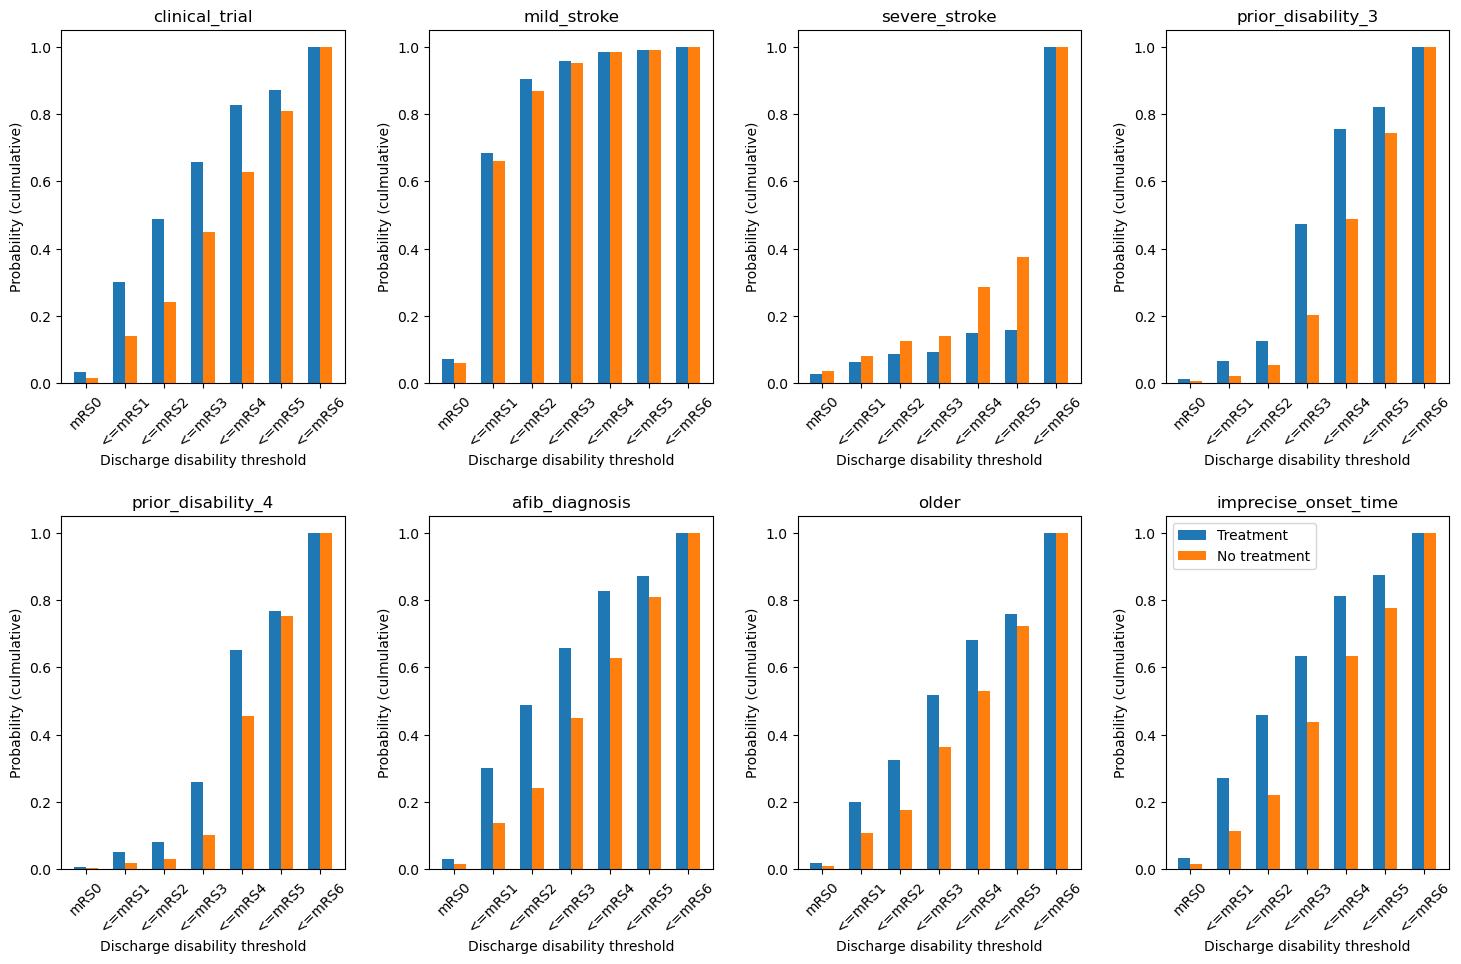

In [18]:
list_get_treatment = ["Treatment","No treatment"]
list_onset_to_thrombolysis_time = [ott_default, -100]

columns=["mRS0","<=mRS1","<=mRS2","<=mRS3","<=mRS4","<=mRS5","<=mRS6"]
index=["with","without"]

# Position of bars on x-axis
ind = np.arange(len(columns))

width = 0.3

fig = plt.figure(figsize=(15, 10))

for patient_loc in range(n_patients):
#    title = df_patient_prototypes.index.values[patient_loc]
    title = df_patient_prototypes.index[patient_loc]
    # take details of this patient
    df_patient_details = pd.DataFrame(columns=list(df_patient_prototypes), 
                                      index=range(len(list_get_treatment)))

    # take exact copy of row
    df_patient_details.iloc[0] = df_patient_prototypes.iloc[patient_loc,:]
    df_patient_details.iloc[1] = df_patient_prototypes.iloc[patient_loc,:]

    # make first copy have, and the second copy not have thrombolysis treatment 
    # (either not get, or get at 2 hours)
    df_patient_details["onset_to_thrombolysis_time"] = (
                                            list_onset_to_thrombolysis_time)

    df_patient_details = df_patient_details.astype('float')

    y_probs = model.predict_proba(df_patient_details)
    y_pred = model.predict(df_patient_details)

    df_patient_mrs_results = pd.DataFrame(data=y_probs, columns=columns, 
                                          index=index)

    df_patient_mrs_results = df_patient_mrs_results.T

    df_bar = create_df_for_bar_plot(df_patient_mrs_results)

    ax1 = fig.add_subplot(2,4,patient_loc+1)
    # Plotting
    mask = df_bar["Treatment"] == list_get_treatment[0]
    cumsum = np.cumsum(df_bar[mask]["Probability"].values)
    ax1.bar(ind, cumsum, width, 
            label=list_get_treatment[0])
    
    mask = df_bar["Treatment"] == list_get_treatment[1]
    cumsum = np.cumsum(df_bar[mask]["Probability"].values)
    ax1.bar(ind + width, cumsum, width, 
            label=list_get_treatment[1])

    plt.xlabel("Discharge disability threshold")
    plt.ylabel("Probability (culmulative)")
    plt.title(title)
    plt.xticks(ind + width / 2, columns, rotation=45)

# Finding the best position for legends and putting it
plt.legend(loc='best')
plt.tight_layout(pad=2)


filename = os.path.join(paths.image_save_path, 
                        (paths.notebook + paths.model_text + 
                         '_cumsum_bar_plot.jpg'))

plt.savefig(filename, dpi=300)

plt.show()

Duration to run notebook

In [19]:
str(datetime.timedelta(seconds=(time.time()-start_time)))

'0:00:02.479709'